In [ ]:
"""
DL model exploration for protein classification using sequence information.
Protein sequence classification is a generalised example of typical problems in model building for biological analyses.

This notebook lists potential considerations for the first exploratory assessment of your data.

NOTE data exploratory analysis will typically involve more steps and for reusability you should build custom helper functions

NOTE this is an exploratory analysis with some examples. You should follow established ML deployment and testing methods to build
applications for analyses.
"""

'\nDL model exploration for protein classification using sequence information\nProtein sequence classification is a generalised example of typical problems in model building for biological analyses\n\nNOTE this is an exploratory analysis with some examples. You should follow established ML deployment and testing methods to build\napplications for analyses.\n'

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow import keras


from keras.preprocessing.text import Tokenizer
from keras import preprocessing
from sklearn.preprocessing import LabelBinarizer

from keras.models import Sequential
from keras.layers import Embedding,Dense,Flatten, Dropout, BatchNormalization,LSTM,Conv1D, MaxPooling1D,AveragePooling1D,SpatialDropout1D, GlobalAveragePooling1D,GlobalMaxPooling1D
from keras.callbacks import EarlyStopping


In [ ]:
#A helper function for a stratified split to balance the data 
from sklearn.model_selection import StratifiedShuffleSplit
def StratifiedSplit(X,y,n_splits=1,test_size=0.2,random_state=0):
  """
  A stratified split for datasets that might require balancing
  #Arguments:
    X; array(int), data frame (int) - data to train on
    y; array(int), data frame (int) - data labels
  #Returns
    train_set, test_set,train_y,test_y; array (int) - stratified split of data
  """
  #Initiate split
  split=StratifiedShuffleSplit(n_splits=n_splits,test_size=test_size,random_state=random_state)
  #Subset data
  for train_index, test_index in split.split(X,y):
    train_set=X[train_index]
    train_y=y[train_index]
    test_set=X[test_index]
    test_y=y[test_index]
  
  return train_set, test_set,train_y,test_y


In [ ]:
#A helper function to validate your model
def model_validation(X_test,y_test,model,lb,batch_size=128):

  """
  NOTE this is a helper function for a classifier

  The model validation function uses the test set where the training was done on a multi-label single class set
  Model labels are one-hot encoded for training where categorical crossentropy is tracked

  #Arguments:
    X_test; array(int), data frame (int) - data to train on
    y_test; array(int), data frame (int) - data labels
    lb; LabelBinarizer (obj) - binarised labels
    batch_size; int - a batch size with a default value of 128
  #Returns
    std out - prints loss and accuracy of the classifier
    std out - prints a classification report
    plt - a confusion matrix
  """
  
  #Evaluate the model with model.evaluate
  results=model.evaluate(X_test,y_test,batch_size=batch_size)
  print("{} loss {} and accuracy {}".format(str(model),results[0],results[1]))

  #Predict labels for the test set
  y_pred=model.predict(X_test)

  #Get classification report
  print(classification_report(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1),target_names=list(lb.classes_)))
  
  #Plot a confusion matrix
  fig,ax=plt.subplots(figsize=(15,15))
  sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1)),annot=True, fmt='g',cmap='Blues')
  ax.set_xticklabels(list(lb.classes_))
  ax.set_yticklabels(list(lb.classes_))
  ax.tick_params(axis='x',rotation=90)
  ax.tick_params(axis='y',rotation=0)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()
  
  return

In [ ]:
def train_validation_plots(history,epoch_num,model_name):

  """
  This is a helper function to plot validation and training outputs for a multi-label classifier
  Parameters plotted include accuracy and loss (categorical_crossentropy)

  #Arguments:
    history; keras(obj)- model training history
    epochnum; int - the number of epochs
    model_name; str - model name
  #Returns
    plt1; std out plot- an accuracy plot
    plt2; std out plot- a loss plot
  """


  plt.plot(range(1,epoch_num+1),history['accuracy'],color='blue',label="Train accuracy")
  plt.plot(range(1,epoch_num+1),history['val_accuracy'],color='red',label="Validation accuracy")
  plt.legend()
  plt.title(model_name)
  plt.show()

  plt.plot(range(1,epoch_num+1),history['loss'],color='blue',label="Train loss")
  plt.plot(range(1,epoch_num+1),history['val_loss'],color='red',label="Validation loss")
  plt.legend()
  plt.title(model_name)
  plt.show()

  return

In [ ]:
def search_existing_model_architectures(X_train,y_train,input_shape, class_num,epochs=10):

  """
  This is a helper function to plot validation and training outputs for a multi-label classifier
  Parameters plotted include accuracy and loss (categorical_crossentropy)

  #Arguments:
    X_train; data frame, array(int) - training features
    y_train; list, array(int) - training labels
    epochs; int- model training epcohs set to 10 as a default value
    input_shape; array(int) - input shape
    class_num; int - class number 
  #Returns
    plt1; std out plot- an accuracy plot
    plt2; std out plot- a loss plot
  """ 


In [ ]:
#Import data and perform a quick exploratory assessment

#from google.colab import files
#data=files.upload()

protein_data=pd.read_csv("/content/pdb_data_no_dups.csv")
protein_seq=pd.read_csv("/content/pdb_data_seq.csv")

print(protein_data.head())
print("Protein data size",protein_data.shape)

print(protein_seq.head())
print("Sequence data size",protein_seq.shape)

  structureId         classification experimentalTechnique macromoleculeType  \
0        100D         DNA-RNA HYBRID     X-RAY DIFFRACTION    DNA/RNA Hybrid   
1        101D                    DNA     X-RAY DIFFRACTION               DNA   
2        101M       OXYGEN TRANSPORT     X-RAY DIFFRACTION           Protein   
3        102D                    DNA     X-RAY DIFFRACTION               DNA   
4        102L  HYDROLASE(O-GLYCOSYL)     X-RAY DIFFRACTION           Protein   

   residueCount  resolution  structureMolecularWeight  \
0            20        1.90                   6360.30   
1            24        2.25                   7939.35   
2           154        2.07                  18112.80   
3            24        2.20                   7637.17   
4           165        1.74                  18926.61   

           crystallizationMethod  crystallizationTempK  densityMatthews  \
0  VAPOR DIFFUSION, HANGING DROP                   NaN             1.78   
1                         

In [ ]:
print("Number of sequences",protein_data.shape[0])
print("Missing data\n",protein_data.isnull().sum())


Number of sequences 141401
Missing data
 structureId                     0
classification                  2
experimentalTechnique           0
macromoleculeType            3765
residueCount                    0
resolution                  12812
structureMolecularWeight        0
crystallizationMethod       45159
crystallizationTempK        44362
densityMatthews             16677
densityPercentSol           16652
pdbxDetails                 22867
phValue                     36291
publicationYear             23799
dtype: int64


In [ ]:
print("Number of sequences",protein_seq.shape[0])
print("Missing data\n",protein_seq.isnull().sum())


Number of sequences 467304
Missing data
 structureId              0
chainId                 10
sequence                28
residueCount             0
macromoleculeType    34817
dtype: int64


In [ ]:
#Select protein data
protein_data=protein_data.loc[protein_data['macromoleculeType']=='Protein',['classification','structureId']]
#protein_data=protein_data.dropna()
protein_seq=protein_seq.loc[protein_seq['macromoleculeType']=='Protein',['structureId','sequence']]
#protein_seq=protein_seq.dropna()


In [ ]:
data=pd.merge(protein_data,protein_seq,how='inner',on=['structureId'])


In [ ]:
print(data.head())
print("Sequence sample number",data.shape[0])

          classification structureId  \
0       OXYGEN TRANSPORT        101M   
1  HYDROLASE(O-GLYCOSYL)        102L   
2       OXYGEN TRANSPORT        102M   
3  HYDROLASE(O-GLYCOSYL)        103L   
4       OXYGEN TRANSPORT        103M   

                                            sequence  
0  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...  
1  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...  
2  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...  
3  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...  
4  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...  
Sequence sample number 346325


In [ ]:
print("Missing data\n",data.isnull().sum())
print("Sequence duplicated data",data['sequence'].duplicated().sum())

Missing data
 classification    1
structureId       0
sequence          3
dtype: int64
Sequence duplicated data 257241


In [ ]:
data=data.drop_duplicates(['sequence'])

In [ ]:
#Remove sequences that are less than 100 amino acids
#NOTE this step will require some adjustments as you have to decide on the optimal sequence length
#this could be tuned during algorithm development as too short sequences will not be informative for the model building

data=data[data['sequence'].apply(lambda x: len(str(x))>=100)]

In [ ]:
#Check data consistency 
#NOTE you can build a helper function to test data consistency regularly during
#the cleaning process
print(data.head())

print("Number of sequences",data.shape[0])
print("Missing data\n",data.isnull().sum())
print("Sequence duplicated data",data['sequence'].duplicated().sum())

          classification structureId  \
0       OXYGEN TRANSPORT        101M   
1  HYDROLASE(O-GLYCOSYL)        102L   
2       OXYGEN TRANSPORT        102M   
3  HYDROLASE(O-GLYCOSYL)        103L   
5  HYDROLASE(O-GLYCOSYL)        104L   

                                            sequence  
0  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...  
1  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...  
2  MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...  
3  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...  
5  MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSAA...  
Number of sequences 72381
Missing data
 classification    0
structureId       0
sequence          0
dtype: int64
Sequence duplicated data 0


In [ ]:
#Assess class distribution
from collections import Counter

data_clasess=Counter(data['classification'])



In [ ]:
data_clasess.most_common()[:10]

[('HYDROLASE', 11069),
 ('TRANSFERASE', 8261),
 ('OXIDOREDUCTASE', 6733),
 ('IMMUNE SYSTEM', 4244),
 ('LYASE', 2430),
 ('TRANSPORT PROTEIN', 1899),
 ('TRANSCRIPTION', 1749),
 ('SIGNALING PROTEIN', 1744),
 ('ISOMERASE', 1509),
 ('VIRAL PROTEIN', 1387)]

In [ ]:
sorted(data_clasess.items(),key=lambda x: x[1],reverse=True)[:10] #another method to check the same information

[('HYDROLASE', 11069),
 ('TRANSFERASE', 8261),
 ('OXIDOREDUCTASE', 6733),
 ('IMMUNE SYSTEM', 4244),
 ('LYASE', 2430),
 ('TRANSPORT PROTEIN', 1899),
 ('TRANSCRIPTION', 1749),
 ('SIGNALING PROTEIN', 1744),
 ('ISOMERASE', 1509),
 ('VIRAL PROTEIN', 1387)]

In [ ]:
classes=[x for x,y in data_clasess.most_common()[:5]]
classes

['HYDROLASE', 'TRANSFERASE', 'OXIDOREDUCTASE', 'IMMUNE SYSTEM', 'LYASE']

In [ ]:
#Extract only data that can be classified 
data_X=data.loc[data["classification"].isin(classes)]
data_X.head()

,classification,structureId,sequence
27,HYDROLASE,117E,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
33,HYDROLASE,11BA,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...
37,TRANSFERASE,11GS,MPPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKA...
135,HYDROLASE,177L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...
137,TRANSFERASE,17GS,MPPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKA...


In [ ]:
print('Total samples',data_X.shape[0])

Total samples 32737


In [ ]:
#Split data into training, validation, and test sets

data_X.reset_index(inplace=True) #reset index for splitting
X=data_X['sequence'].astype('str')
y=data_X['classification'].astype('str')

#Chose different types of splitting depending on your data composition
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, stratify=y,random_state=0)
X_train,X_test,y_train,y_test=StratifiedSplit(X,y,n_splits=1,test_size=0.2,random_state=0)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test set distribution')

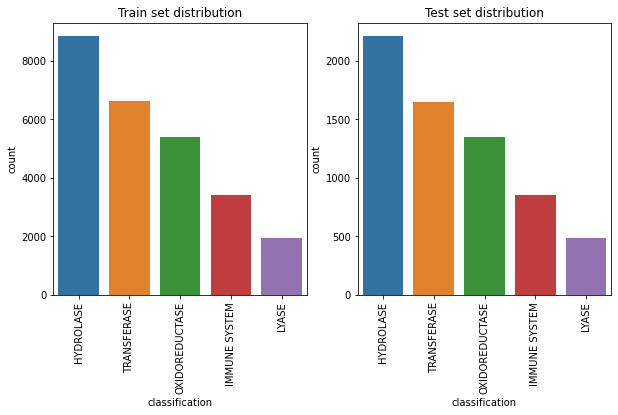

In [ ]:
#Assess split distribution
fig,ax=plt.subplots(1,2, figsize=(10,5))

sns.countplot(y_train,ax=ax[0], order=y_train.value_counts().index,)
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title(label="Train set distribution")
sns.countplot(y_test,ax=ax[1],order=y_test.value_counts().index)
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title(label="Test set distribution")

In [ ]:
#Get lengths of seuquences
train_lengths=[len(x) for x in list(X_train)]
test_lengths=[len(x) for x in list(X_test)]

Text(0.5, 1.0, 'Test set sequence lengths')

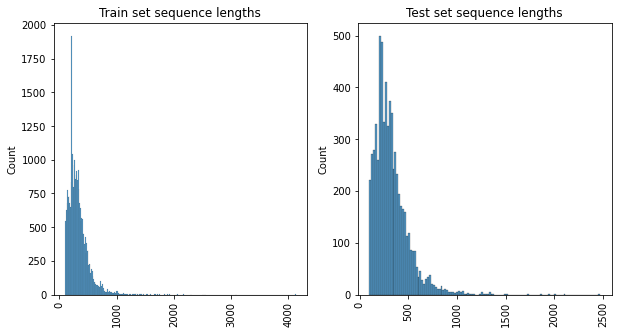

In [ ]:
#Assess sequence distribution


fig,ax=plt.subplots(1,2, figsize=(10,5))

sns.histplot(train_lengths,ax=ax[0])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title(label="Train set sequence lengths")
sns.histplot(test_lengths,ax=ax[1])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title(label="Test set sequence lengths")

<BarContainer object of 26189 artists>

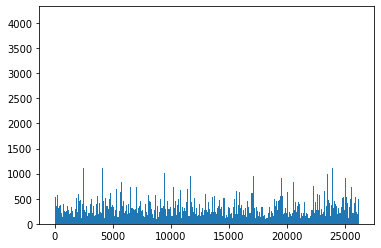

In [ ]:
#Check if lengths have varied distribution not to bias the model during the training
plt.bar(range(1,len(train_lengths)+1),train_lengths,width=1.0)

In [ ]:
#Tokenize the data
#NOTE tokenisation and labelling of the test set should be based on the training set

#PARAMETERS

MAXLEN=350 #set max length of the sequence


tokenizer=Tokenizer(char_level=True)
tokenizer.fit_on_texts(list(X_train.values))

X_train=tokenizer.texts_to_sequences(X_train.values)
X_test=tokenizer.texts_to_sequences(X_test.values)

X_train=preprocessing.sequence.pad_sequences(X_train,maxlen=MAXLEN)
X_test=preprocessing.sequence.pad_sequences(X_test,maxlen=MAXLEN)

VOCAB_SIZE=len(tokenizer.word_index)+1

#Binarize labels
lb=LabelBinarizer()
y_train=lb.fit_transform(y_train)
y_test=lb.transform(y_test)

In [ ]:
print("Word index",tokenizer.word_index)
print("Vocabulary size",VOCAB_SIZE)
print(len(y_train[0]))
print(X_train.shape)


Word index {'l': 1, 'a': 2, 'g': 3, 'v': 4, 's': 5, 'e': 6, 'd': 7, 't': 8, 'k': 9, 'i': 10, 'r': 11, 'p': 12, 'n': 13, 'f': 14, 'q': 15, 'y': 16, 'h': 17, 'm': 18, 'w': 19, 'c': 20, 'x': 21, 'z': 22, 'b': 23, 'u': 24, 'o': 25}
Vocabulary size 26
5
(26189, 350)


# Starting model exploration

Searching for an optimal model should consist of testing various baselines and in parallel exploring various model architectures.

Below you can find several exploratory set-ups that can be used to test initial assumptions about data and decide on what more complex architectures could be used.

Trade-offs between bias and variance as well as the model's ability to generalise should be considered.

**NOTE** you should save various model configurations and you can test them later or build a function to tune parameters

In [ ]:
#Prepare the model 1

#NOTE after initial data assessment a more concice model structure should be implemented either via Tensor base models or class models.
#Thes initial observations can be used to guide further model tuning and/or model search

EMBEDDING_DIMS=25 #also consider VOCAB_SIZE-1
CLASSES_NUM=5

model1=Sequential()
model1.add(Embedding(VOCAB_SIZE,EMBEDDING_DIMS,input_length=MAXLEN))

#model1.add(Conv1D(filters=256,kernel_size=12,activation='relu', padding='same'))


model1.add(Conv1D(filters=128,kernel_size=25,activation='relu', padding='same'))
#model1.add(MaxPooling1D(pool_size=2))
#model1.add(AveragePooling1D(pool_size=2))
model1.add(Conv1D(filters=128,kernel_size=25,activation='relu', padding='valid'))
model1.add(MaxPooling1D(pool_size=2))
#model1.add(AveragePooling1D(pool_size=2))
model1.add(Conv1D(filters=64,kernel_size=10,activation='relu', padding='valid'))
model1.add(MaxPooling1D(pool_size=2))
#model1.add(AveragePooling1D(pool_size=2))
#model1.add(Conv1D(filters=16,kernel_size=3,activation='relu', padding='valid'))
#model1.add(MaxPooling1D(pool_size=2))

model1.add(Flatten())
#model1.add(GlobalAveragePooling1D())
#model1.add(Dense(2048,activation='relu'))
model1.add(Dense(1024,activation='relu'))
#model1.add(BatchNormalization())
#model1.add(Dropout(0.2))
model1.add(Dense(512,activation='relu'))
#model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(256,activation='relu'))
#model1.add(BatchNormalization())
#model1.add(Dropout(0.2))
model1.add(Dense(128,activation='relu'))
#model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(64,activation='relu'))
#model1.add(BatchNormalization())
#model1.add(Dropout(0.2))
model1.add(Dense(32,activation='relu'))
#model1.add(Dropout(0.2))
model1.add(Dense(CLASSES_NUM,activation='softmax'))

model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 25)           650       
                                                                 
 conv1d (Conv1D)             (None, 350, 128)          80128     
                                                                 
 conv1d_1 (Conv1D)           (None, 326, 128)          409728    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 163, 128)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 154, 64)           81984     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 77, 64)           0         
 1D)                                                    

In [ ]:
#Set parameters
ES=EarlyStopping(monitor="val_accuracy",verbose=1,patience=3)
EPOCHS=100
BATCHSIZE=100
history=model1.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCHSIZE,validation_split=0.2,callbacks=[ES])
#model.save("model1_h5.h5")


Epoch 1/100
147/147 [==============================] - 17s 31ms/step - loss: 1.3767 - accuracy: 0.3691 - val_loss: 1.2424 - val_accuracy: 0.4418
Epoch 2/100
147/147 [==============================] - 4s 28ms/step - loss: 1.2155 - accuracy: 0.4563 - val_loss: 1.1353 - val_accuracy: 0.5049
Epoch 3/100
147/147 [==============================] - 4s 27ms/step - loss: 1.1358 - accuracy: 0.4836 - val_loss: 1.0463 - val_accuracy: 0.5441
Epoch 4/100
147/147 [==============================] - 4s 28ms/step - loss: 0.9738 - accuracy: 0.5681 - val_loss: 0.9561 - val_accuracy: 0.5836
Epoch 5/100
147/147 [==============================] - 4s 27ms/step - loss: 0.7905 - accuracy: 0.6758 - val_loss: 0.8082 - val_accuracy: 0.6873
Epoch 6/100
147/147 [==============================] - 4s 28ms/step - loss: 0.5666 - accuracy: 0.7827 - val_loss: 0.7504 - val_accuracy: 0.7387
Epoch 7/100
147/147 [==============================] - 4s 28ms/step - loss: 0.4243 - accuracy: 0.8517 - val_loss: 0.8622 - val_accuracy

In [ ]:
epoch_num=history.epoch[-1]+1

In [ ]:
history=history.history
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
#Best epoch
np.argmax(history['val_accuracy'])

14

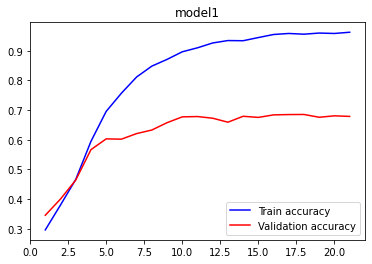

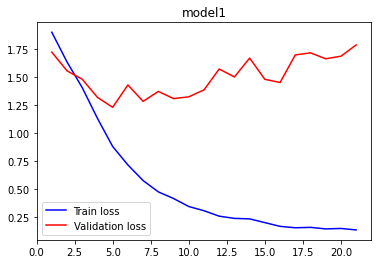

In [ ]:
"""plt.plot(range(1,epoch_num+1),history['accuracy'],color='blue',label="Train accuracy")
plt.plot(range(1,epoch_num+1),history['val_accuracy'],color='red',label="Validation accuracy")
plt.legend()
plt.show()

plt.plot(range(1,epoch_num+1),history['loss'],color='blue',label="Train loss")
plt.plot(range(1,epoch_num+1),history['val_loss'],color='red',label="Validation loss")
plt.legend()
plt.show()"""

train_validation_plots(history,epoch_num,'model1')

65/65 [==============================] - 1s 8ms/step - loss: 1.7775 - accuracy: 0.6845
<keras.engine.sequential.Sequential object at 0x7f40ea3ae0d0> loss 1.77747642993927 and accuracy 0.6844606995582581
                   precision    recall  f1-score   support

        HYDROLASE       0.69      0.78      0.73      2214
    IMMUNE SYSTEM       0.88      0.84      0.86       849
        ISOMERASE       0.74      0.43      0.55       302
            LYASE       0.68      0.58      0.63       486
   OXIDOREDUCTASE       0.72      0.75      0.73      1346
SIGNALING PROTEIN       0.51      0.39      0.44       349
    TRANSCRIPTION       0.60      0.40      0.48       350
      TRANSFERASE       0.61      0.70      0.65      1652
TRANSPORT PROTEIN       0.70      0.45      0.55       380
    VIRAL PROTEIN       0.65      0.54      0.59       277

         accuracy                           0.68      8205
        macro avg       0.68      0.59      0.62      8205
     weighted avg       0.69

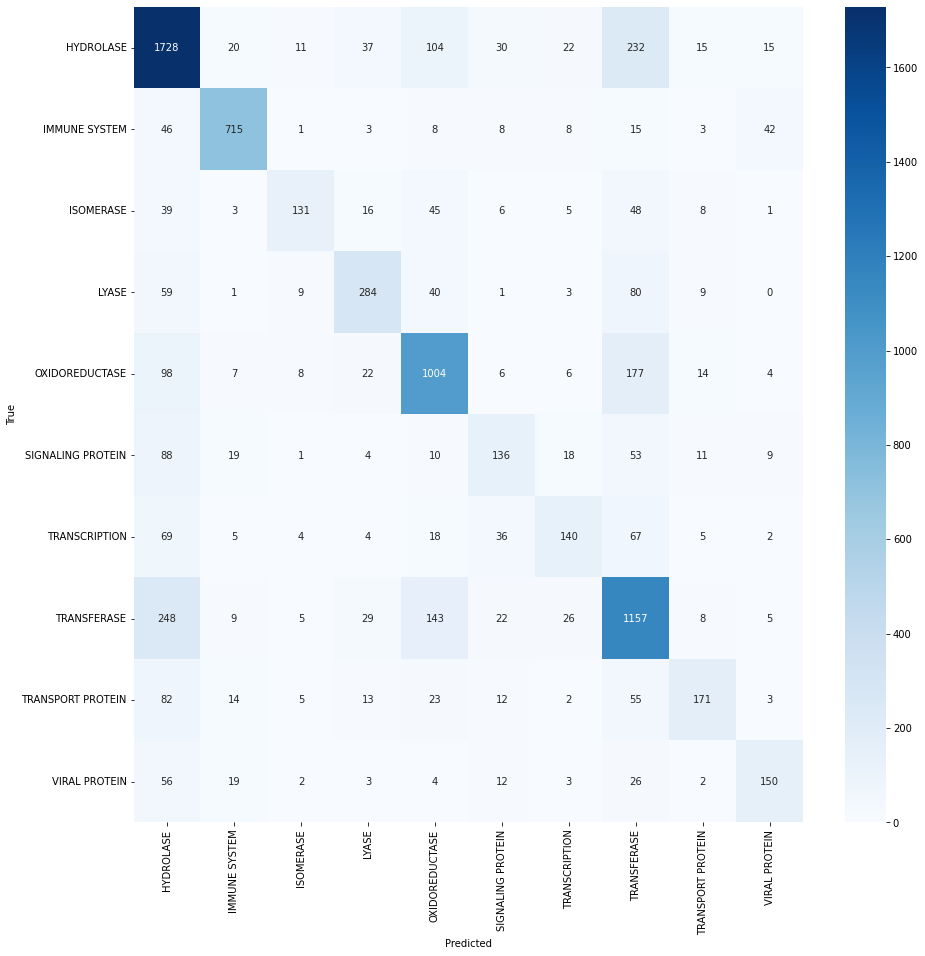

In [ ]:
model_validation(X_test,y_test,model1,lb,batch_size=128)

In [ ]:
#Prepare the model 2

EMBEDDING_DIMS=64 #VOCAB_SIZE-1
CLASSES_NUM=10

model2=Sequential()
model2.add(Embedding(VOCAB_SIZE,EMBEDDING_DIMS,input_length=MAXLEN))



model2.add(Conv1D(filters=512,kernel_size=32,activation='relu', padding='same'))

model2.add(Conv1D(filters=256,kernel_size=24,activation='relu', padding='valid'))
model2.add(AveragePooling1D())
model2.add(Conv1D(filters=128,kernel_size=12,activation='relu', padding='valid'))
model2.add(AveragePooling1D())
model2.add(Conv1D(filters=64,kernel_size=6,activation='relu', padding='valid'))
model2.add(AveragePooling1D())
model2.add(Conv1D(filters=32,kernel_size=3,activation='relu', padding='valid'))
model2.add(MaxPooling1D())

model2.add(Flatten())
#model2.add(Dense(4096,activation='relu'))
model2.add(Dense(2048,activation='relu'))
#model2.add(BatchNormalization())
model2.add(Dense(1024,activation='relu'))
#model2.add(BatchNormalization())
model2.add(Dense(512,activation='relu'))
#model2.add(BatchNormalization())
model2.add(Dense(256,activation='relu'))
#model2.add(BatchNormalization())
model2.add(Dropout(0.2))
#model2.add(BatchNormalization())
model2.add(Dense(128,activation='relu'))
#model2.add(BatchNormalization())
model2.add(Dense(64,activation='relu'))
#model2.add(BatchNormalization())
#model2.add(Dropout(0.2))
model2.add(Dense(32,activation='relu'))
#model2.add(Dropout(0.2))
model2.add(Dense(CLASSES_NUM,activation='softmax'))

model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_77 (Embedding)    (None, 350, 64)           1664      
                                                                 
 conv1d_258 (Conv1D)         (None, 350, 512)          1049088   
                                                                 
 conv1d_259 (Conv1D)         (None, 327, 256)          3145984   
                                                                 
 average_pooling1d_31 (Avera  (None, 163, 256)         0         
 gePooling1D)                                                    
                                                                 
 conv1d_260 (Conv1D)         (None, 152, 128)          393344    
                                                                 
 average_pooling1d_32 (Avera  (None, 76, 128)          0         
 gePooling1D)                                        

Epoch 1/100
263/263 [==============================] - 36s 126ms/step - loss: 1.8920 - accuracy: 0.3074 - val_loss: 1.7177 - val_accuracy: 0.3598
Epoch 2/100
263/263 [==============================] - 32s 120ms/step - loss: 1.6181 - accuracy: 0.4009 - val_loss: 1.5835 - val_accuracy: 0.4292
Epoch 3/100
263/263 [==============================] - 32s 122ms/step - loss: 1.3540 - accuracy: 0.5123 - val_loss: 1.3566 - val_accuracy: 0.5201
Epoch 4/100
263/263 [==============================] - 33s 124ms/step - loss: 1.0653 - accuracy: 0.6161 - val_loss: 1.2506 - val_accuracy: 0.5803
Epoch 5/100
263/263 [==============================] - 33s 125ms/step - loss: 0.8677 - accuracy: 0.6936 - val_loss: 1.3115 - val_accuracy: 0.5836
Epoch 6/100
263/263 [==============================] - 33s 126ms/step - loss: 0.7124 - accuracy: 0.7581 - val_loss: 1.2176 - val_accuracy: 0.6193
Epoch 7/100
263/263 [==============================] - 33s 126ms/step - loss: 0.6109 - accuracy: 0.7946 - val_loss: 1.3295 -

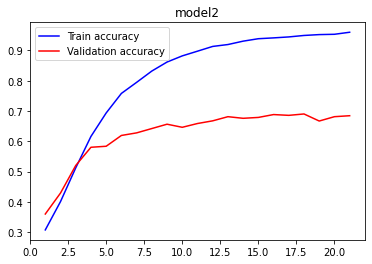

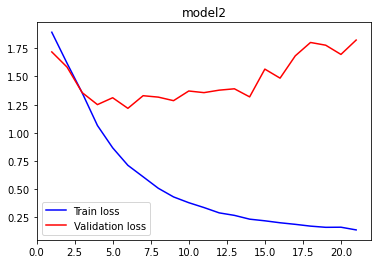

65/65 [==============================] - 3s 30ms/step - loss: 1.8608 - accuracy: 0.6767
<keras.engine.sequential.Sequential object at 0x7f40e62a2f90> loss 1.8608026504516602 and accuracy 0.6766605973243713
                   precision    recall  f1-score   support

        HYDROLASE       0.77      0.70      0.73      2214
    IMMUNE SYSTEM       0.94      0.86      0.90       849
        ISOMERASE       0.46      0.52      0.49       302
            LYASE       0.63      0.58      0.61       486
   OXIDOREDUCTASE       0.69      0.75      0.72      1346
SIGNALING PROTEIN       0.46      0.39      0.42       349
    TRANSCRIPTION       0.48      0.49      0.48       350
      TRANSFERASE       0.60      0.74      0.66      1652
TRANSPORT PROTEIN       0.62      0.46      0.53       380
    VIRAL PROTEIN       0.64      0.49      0.55       277

         accuracy                           0.68      8205
        macro avg       0.63      0.60      0.61      8205
     weighted avg       0

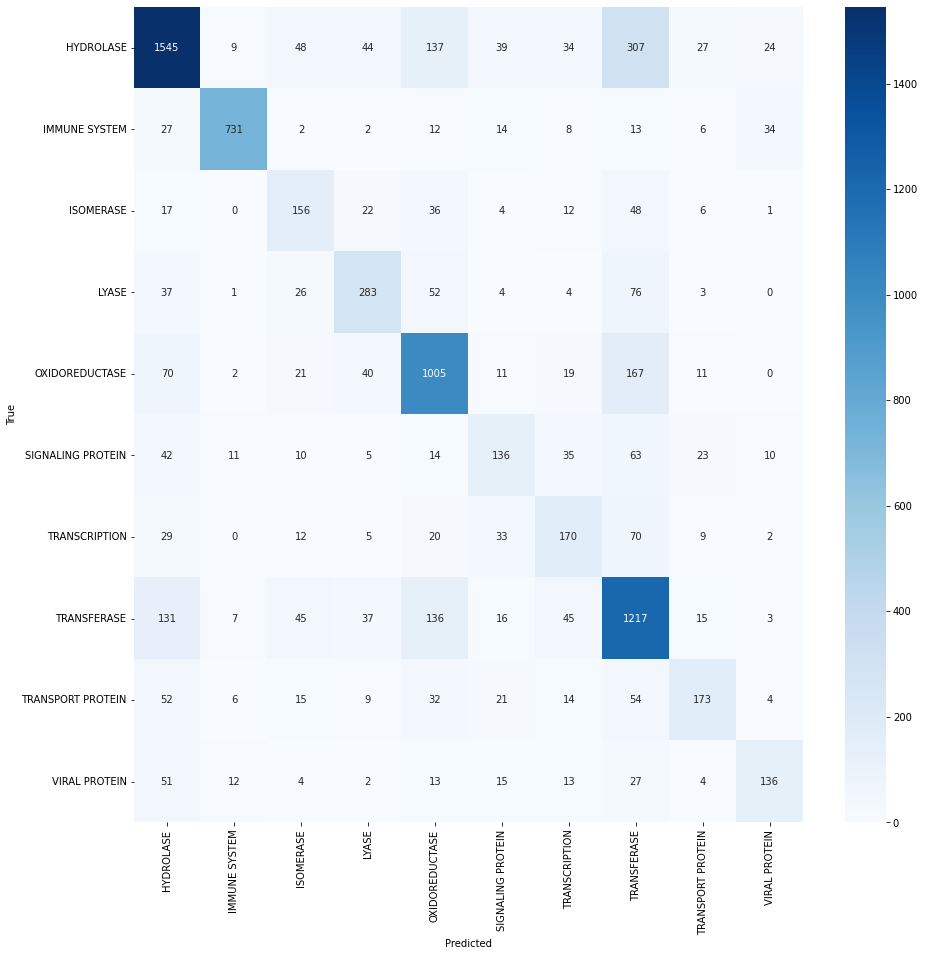

In [ ]:
#Evaluate model 2
history=model2.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCHSIZE,validation_split=0.2,callbacks=[ES])
#model.save("model2_h5.h5")
epoch_num=history.epoch[-1]+1
history=history.history
#Best epoch
print("Best epoch",np.argmax(history['val_accuracy']))
train_validation_plots(history,epoch_num,'model2')
model_validation(X_test,y_test,model2,lb,batch_size=128) 

In [ ]:
#Prepare the model 3

EMBEDDING_DIMS=128
CLASSES_NUM=10

model3=Sequential()
model3.add(Embedding(VOCAB_SIZE,EMBEDDING_DIMS,input_length=MAXLEN))

model3.add(LSTM(EMBEDDING_DIMS, return_sequences=True)) #assess overfiting
model3.add(LSTM(EMBEDDING_DIMS//2, return_sequences=True))
model3.add(LSTM(EMBEDDING_DIMS//2, return_sequences=True))
model3.add(Flatten())
"""model3.add(LSTM(EMBEDDING_DIMS, return_sequences=True))
model3.add(LSTM(EMBEDDING_DIMS, return_sequences=True))

model3.add(Flatten())
model3.add(Dense(5012,activation='relu'))
model3.add(Dense(2048,activation='relu'))
#model3.add(BatchNormalization())

"""
model3.add(Dense(1024,activation='relu'))
#model3.add(BatchNormalization())
#model3.add(Dropout(0.25))
model3.add(Dense(512,activation='relu'))
#model3.add(BatchNormalization())
model3.add(Dense(256,activation='relu'))
#model3.add(BatchNormalization())
model3.add(Dropout(0.2))
model3.add(Dense(128,activation='relu'))
#model3.add(BatchNormalization())
model3.add(Dense(64,activation='relu'))
#model3.add(BatchNormalization())
#model3.add(Dropout(0.2))
model3.add(Dense(32,activation='relu'))
#model3.add(Dropout(0.2))
model3.add(Dense(CLASSES_NUM,activation='softmax'))

model3.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_82 (Embedding)    (None, 350, 128)          3328      
                                                                 
 lstm_12 (LSTM)              (None, 350, 128)          131584    
                                                                 
 lstm_13 (LSTM)              (None, 350, 64)           49408     
                                                                 
 lstm_14 (LSTM)              (None, 350, 64)           33024     
                                                                 
 flatten_55 (Flatten)        (None, 22400)             0         
                                                                 
 dense_402 (Dense)           (None, 1024)              22938624  
                                                                 
 dense_403 (Dense)           (None, 512)             

Epoch 1/100
263/263 [==============================] - 23s 69ms/step - loss: 1.7727 - accuracy: 0.3593 - val_loss: 1.6099 - val_accuracy: 0.4328
Epoch 2/100
263/263 [==============================] - 17s 66ms/step - loss: 1.4972 - accuracy: 0.4839 - val_loss: 1.3617 - val_accuracy: 0.5363
Epoch 3/100
263/263 [==============================] - 17s 66ms/step - loss: 1.1959 - accuracy: 0.6018 - val_loss: 1.1859 - val_accuracy: 0.6091
Epoch 4/100
263/263 [==============================] - 18s 67ms/step - loss: 0.8732 - accuracy: 0.7163 - val_loss: 1.1522 - val_accuracy: 0.6495
Epoch 5/100
263/263 [==============================] - 17s 65ms/step - loss: 0.6030 - accuracy: 0.8089 - val_loss: 1.1602 - val_accuracy: 0.6843
Epoch 6/100
263/263 [==============================] - 18s 67ms/step - loss: 0.4238 - accuracy: 0.8673 - val_loss: 1.1286 - val_accuracy: 0.6974
Epoch 7/100
263/263 [==============================] - 18s 69ms/step - loss: 0.2847 - accuracy: 0.9142 - val_loss: 1.4262 - val_ac

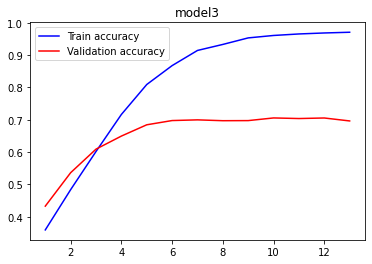

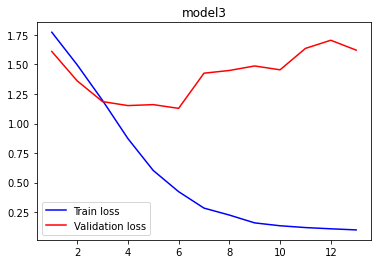

65/65 [==============================] - 2s 26ms/step - loss: 1.6986 - accuracy: 0.6857
<keras.engine.sequential.Sequential object at 0x7f43377d8a90> loss 1.698639988899231 and accuracy 0.6856794357299805
                   precision    recall  f1-score   support

        HYDROLASE       0.69      0.76      0.72      2214
    IMMUNE SYSTEM       0.87      0.85      0.86       849
        ISOMERASE       0.64      0.50      0.56       302
            LYASE       0.70      0.57      0.63       486
   OXIDOREDUCTASE       0.77      0.72      0.74      1346
SIGNALING PROTEIN       0.49      0.35      0.41       349
    TRANSCRIPTION       0.47      0.55      0.51       350
      TRANSFERASE       0.66      0.71      0.69      1652
TRANSPORT PROTEIN       0.51      0.49      0.50       380
    VIRAL PROTEIN       0.61      0.55      0.58       277

         accuracy                           0.69      8205
        macro avg       0.64      0.61      0.62      8205
     weighted avg       0.

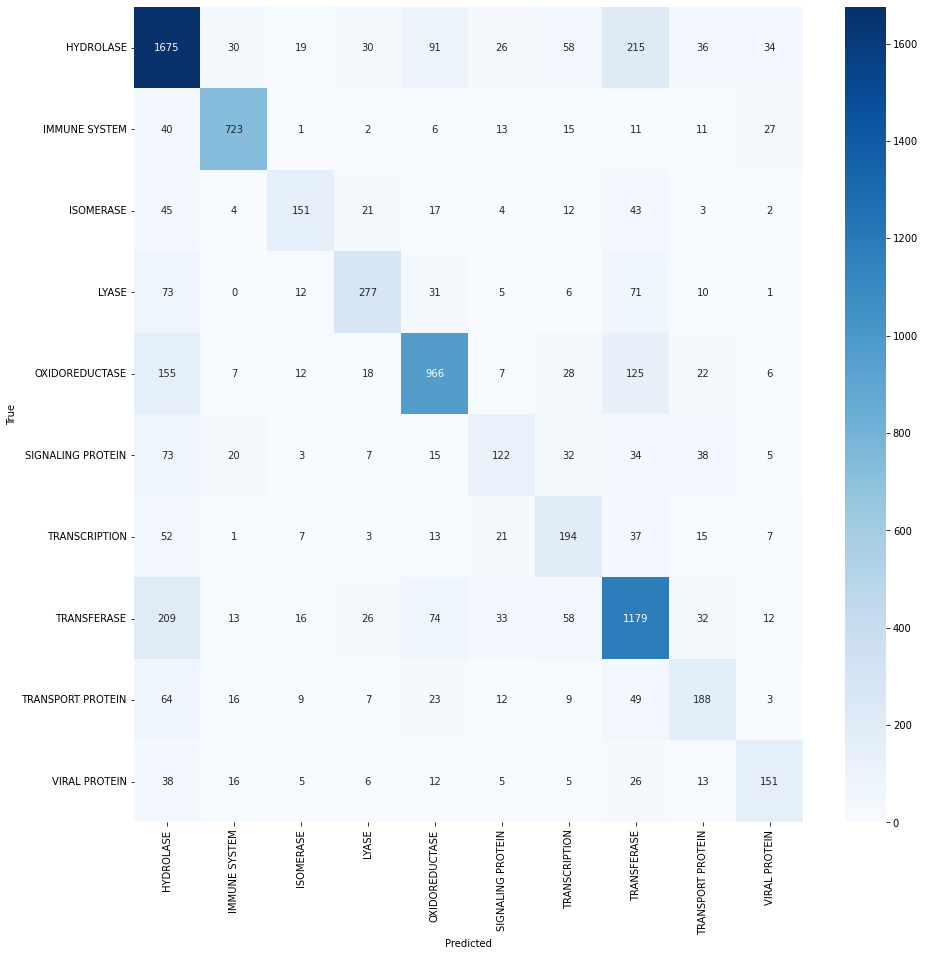

In [ ]:
#Evaluate model 3
history=model3.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCHSIZE,validation_split=0.2,callbacks=[ES])
#model.save("model3_h5.h5")
epoch_num=history.epoch[-1]+1
history=history.history
#Best epoch
print("Best epoch",np.argmax(history['val_accuracy']))
train_validation_plots(history,epoch_num,'model3')
model_validation(X_test,y_test,model3,lb,batch_size=128) 

## Getting insights

After an initial assessment of data's behavior, you can begin deciding on the optimal number of features (e.g., some classes might not be representative or data needs to be further cleaned, etc.). 

You can also build a model builder function to iterate and explore a finer space of model hyperparameters as your second analytical step.

Once you decide on the optimal model configuration, you can begin to train, test, and deploy your model with appropriate monitoring tools and strategies.